In [14]:
import math
import pickle
import gzip
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

from math import exp
import kagglehub
import numpy as np
import pandas as pd
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score

In [15]:
# This cell sets up the MNIST dataset 


# Download latest version
path = kagglehub.dataset_download("aadeshkoirala/mnist-784")

class MNIST_import:
    """
    sets up MNIST dataset from OpenML 
    """
    def __init__(self):
        
        df = pd.read_csv(f"{path}/mnist_784.csv")
        
        # Create arrays for the features and the response variable
        # store for use later 
        y = df['class'].values
        X = df.drop('class', axis=1).values
         
        # Convert the labels to numeric labels
        y = np.array(pd.to_numeric(y))
        
        # create training and validation sets 
        self.train_x, self.train_y = X[:5000,:], y[:5000]
        self.val_x, self.val_y = X[5000:6000,:], y[5000:6000]
        
data = MNIST_import()

In [16]:
def view_digit(x, label=None):
    fig = plt.figure(figsize=(3,3))
    plt.imshow(x.reshape(28,28), cmap='gray');
    plt.xticks([]); plt.yticks([]);
    if label: plt.xlabel("true: {}".format(label), fontsize=16)

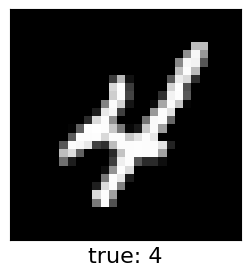

In [17]:
# Select the first image and its label from the training set
x = data.train_x[9]
label = data.train_y[9]

view_digit(x, label)
plt.show()  # Show the plot

We won't use Scikit-Learn's KNeighborsClassifier in this problem. We're implementing this ourselves.

In [18]:
class KNN:
    """
    Class to store data for regression problems 
    """
    def __init__(self, x_train, y_train, K=5):
        """
        Creates a kNN instance

        :param x_train: numpy array with shape (n_rows,1)- e.g. [[1,2],[3,4]]
        :param y_train: numpy array with shape (n_rows,)- e.g. [1,-1]
        :param K: The number of nearest points to consider in classification
        """
        
        # Import and build the BallTree on training features 
        from sklearn.neighbors import BallTree
        self.balltree = BallTree(x_train)
        
        # Cache training labels and parameter K 
        self.y_train = y_train
        self.K = K 
        
        
    def majority(self, neighbor_indices, neighbor_distances=None):
        """
        Given indices of nearest neighbors in training set, return the majority label. 
        Break ties by considering 1 fewer neighbor until a clear winner is found. 

        :param neighbor_indices: The indices of the K nearest neighbors in self.X_train 
        :param neighbor_distances: Corresponding distances from query point to K nearest neighbors. 
        """
        
        
        while self.K > 0:
            # Get the labels of the K nearest neighbors
            labels = self.y_train[neighbor_indices[:self.K]]
            
            # Count the occurrences of each label
            label_counts = {}
            for label in labels:
                if label in label_counts:
                    label_counts[label] += 1
                else:
                    label_counts[label] = 1
                
            
            # Find the label with the maximum count
            max_count = max(label_counts.values())
            candidates = [label for label, count in label_counts.items() if count == max_count]
            
            # If there's a clear majority, return it
            if len(candidates) == 1:
                return candidates[0]
            
            # Otherwise, reduce K by 1 and try again
            self.K -= 1
        
        # If K reaches 0, return the first label (though this should not happen with K >= 1)
        return labels[0]
            
        
    def classify(self, x):
        """
        Given a query point, return the predicted label 
        
        :param x: a query point stored as an ndarray  
        """
        
        # Find the K nearest neighbors
        distances, indices = self.balltree.query(x.reshape(1, -1), k=self.K)
        
        # Get the majority label
        return self.majority(indices[0], distances[0])
        
    def predict(self, X):
        """
        Given an ndarray of query points, return yhat, an ndarray of predictions 

        :param X: an (m x p) dimension ndarray of points to predict labels for 
        """
        
        # Initialize an empty array to store predictions
        predictions = np.zeros(X.shape[0], dtype=int)
        
        # Iterate over each query point and classify it
        for i, x in enumerate(X):
            predictions[i] = self.classify(x)
        
        return predictions

In [19]:
# Sample tests for KNN class

import pytest
# set-up
X_train = np.array([[1,6], [6,4], [2,5], [1,3], [2,2], [3,1], [1,5], [2,3], [4,6], [3,5], [6,5], [0,4]])
y_train = np.array([+1, -1, +1, +1, -1, +1, +1, -1, +1, -1, +1, -1])
x = np.array([0,5])

# test k=2,
k2nn = KNN(X_train, y_train, K=2)
assert -1 == pytest.approx(k2nn.classify(x)), "KNN class doesn't perform as expected with two neighbors"


# test k=3
k3nn = KNN(X_train, y_train, K=3) 
assert 1 == pytest.approx(k3nn.classify(x)), "KNN class doesn't perform as expected with three neighbors"


# test 3NN Predict 
X = np.array([[2,5], [5,1]])
k3p = KNN(X_train, y_train, K=3) 
yhat = k3p.predict(X)

# correct labels for the above two points(X).
ytrue = [1, -1]

for yh, yt in zip(yhat, ytrue):
    assert yh == yt, "Look at the predict function in the KNN class."

use KNN class to perform KNN on the validation data with K = 3

In [20]:
# use your KNN class to perform KNN on the validation data with K = 3
knn = KNN(data.train_x, data.train_y, K=3)
val_yhat = knn.predict(data.val_x)


In [21]:
# create a confusion matrix 
sklearn.metrics.confusion_matrix(data.val_y, val_yhat, labels=None, sample_weight=None, normalize=None)

array([[112,   0,   0,   0,   0,   0,   1,   0,   0,   0],
       [  0, 106,   0,   0,   0,   0,   0,   1,   0,   1],
       [  1,   2,  87,   2,   0,   0,   0,   1,   0,   0],
       [  1,   0,   2, 109,   0,   3,   0,   0,   0,   0],
       [  0,   2,   0,   0,  82,   0,   0,   0,   0,   4],
       [  0,   0,   0,   3,   2,  73,   2,   0,   0,   0],
       [  0,   0,   0,   0,   0,   1, 104,   0,   2,   0],
       [  0,   2,   0,   1,   0,   1,   0,  89,   0,   8],
       [  1,   1,   0,   2,   0,   0,   2,   2,  80,   1],
       [  1,   0,   0,   1,   1,   0,   0,   2,   0, 101]])

K = 1; Accuracy: 0.942
K = 2; Accuracy: 0.942
K = 3; Accuracy: 0.943
K = 4; Accuracy: 0.943
K = 5; Accuracy: 0.944
K = 6; Accuracy: 0.944
K = 7; Accuracy: 0.944
K = 8; Accuracy: 0.944
K = 9; Accuracy: 0.944
K = 10; Accuracy: 0.944
K = 11; Accuracy: 0.936
K = 12; Accuracy: 0.936
K = 13; Accuracy: 0.936
K = 14; Accuracy: 0.935
K = 15; Accuracy: 0.935
K = 16; Accuracy: 0.935
K = 17; Accuracy: 0.935
K = 18; Accuracy: 0.933
K = 19; Accuracy: 0.933
K = 20; Accuracy: 0.933
K = 21; Accuracy: 0.925
K = 22; Accuracy: 0.925
K = 23; Accuracy: 0.925
K = 24; Accuracy: 0.925
K = 25; Accuracy: 0.911
K = 26; Accuracy: 0.91
K = 27; Accuracy: 0.91
K = 28; Accuracy: 0.91
K = 29; Accuracy: 0.909
K = 30; Accuracy: 0.909


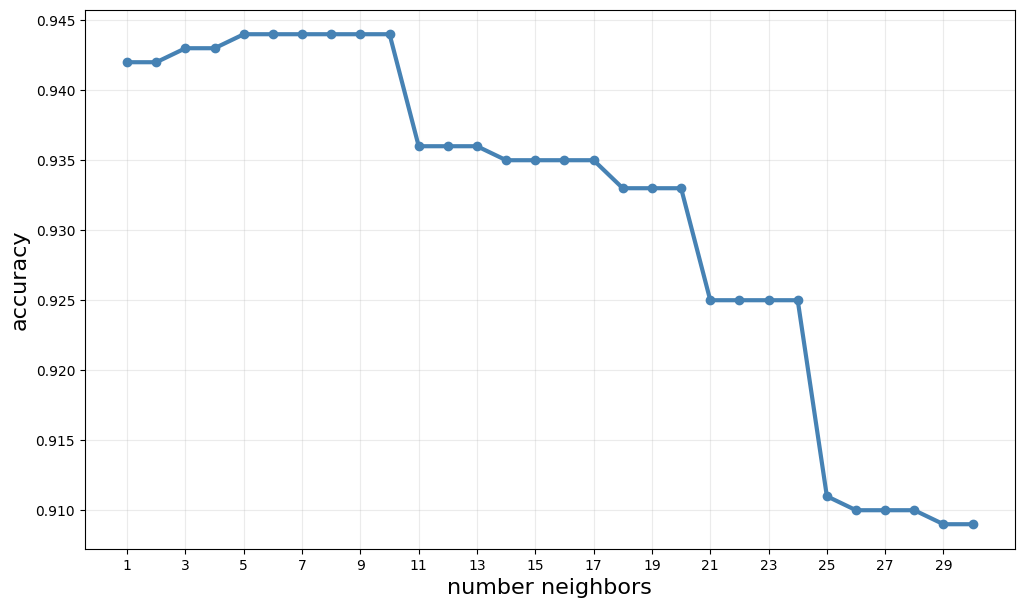

In [25]:
# Accuracy plot
acc = []
wacc = []
allks = range(1,31)
for k in allks:
    # train the k-Nearest Neighbor classifier with the current value of `k`
    model = KNN(data.train_x, data.train_y, K=k)
    # evaluate the model and update the accuracies list
    val_yhat = model.predict(data.val_x)
    accuracy = accuracy_score(data.val_y, val_yhat)
    acc.append(accuracy)
    print("K = "+str(k)+"; Accuracy: "+str(accuracy))


# create plot   
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
ax.plot(allks, acc, marker="o", color="steelblue", lw=3, label="unweighted")
ax.set_xlabel("number neighbors", fontsize=16)
ax.set_ylabel("accuracy", fontsize=16)
plt.xticks(range(1,31,2))
ax.grid(alpha=0.25)